In [1]:
%load_ext zipline

In [97]:
from cryptohist import CoinMarketCapFetcher
from collections import OrderedDict
import pandas as pd
import datetime as dt
import pytz

fetcher = CoinMarketCapFetcher(start=dt.datetime(2013, 4, 28), end=dt.datetime.today())

symbols = set(fetcher.get_symbols())
data = OrderedDict()
market_caps = OrderedDict()
volumes = OrderedDict()
for symbol in symbols:
    data[symbol] = pd.read_csv("data/" + symbol + ".csv")
    
    data[symbol]['date'] = pd.to_datetime(data[symbol]['Date'])
    data[symbol].set_index('date', inplace=True)
    data[symbol].drop('Date', axis=1, inplace=True)
    data[symbol].fillna(method="ffill", inplace=True)
    market_caps[symbol] = data[symbol][["Market Cap"]].copy().fillna(0)
    volumes[symbol] = data[symbol][["Volume"]].copy().fillna(0)
    data[symbol] = data[symbol][["Low","High","Open","Close","Volume"]]


panel = pd.Panel(data)
panel.minor_axis = ["low","high","open","close","volume"]
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 891 (items) x 1831 (major_axis) x 5 (minor_axis)
Items axis: NLG to AMMO
Major_axis axis: 2013-04-28 00:00:00+00:00 to 2018-05-02 00:00:00+00:00
Minor_axis axis: low to volume


In [83]:
config = {
        "name": "index",
        "top": 20,
        "max_percent": 0.1,
}

In [84]:
def coins_market_cap(market_caps, today):
    coins = []
    for s in symbols:
        try:
            coins.append({"symbol": s, "value": market_caps[s].loc[today]["Market Cap"]})
        except KeyError:
            pass
    return coins

def coins_mean_volume(data, days):
    coins = []
    for s in symbols:
        try:
            coins.append({"symbol": s, "value": data.history(symbol(s), 'volume', bar_count=days, frequency="1d").mean()})
        except ValueError:
            pass
    return coins

In [85]:
from zipline.api import order, record, symbol, set_benchmark, set_commission, set_slippage, order_target_percent, get_open_orders, get_datetime, order_percent
from index import calc_allocation, rebalance
from zipline.finance import commission, slippage


def initialize(context):
    set_benchmark(symbol("BTC"))
    set_benchmark(symbol("ETH"))
    set_slippage(slippage.FixedSlippage(spread=0))
    set_commission(commission.PerTrade(cost=1))
    context.i = -1
    context.rebalance_days = 14


def handle_data(context, data):
    context.i += 1
    record(BTC=data.current(symbol('BTC'), fields='price'))
    record(ETH=data.current(symbol('ETH'), fields='price'))
    if context.i % context.rebalance_days != 0:
        return
    
    today = str(get_datetime().date())
    coins = coins_market_cap(market_caps, today)
    allocation = calc_allocation(coins, config)
    holdings = {e.symbol:p.amount for e, p in context.portfolio.positions.items()}
    prices = {s:data.current(symbol(s), fields='price') for s in allocation.keys() | holdings.keys()}
    value = context.portfolio.portfolio_value
    transactions = rebalance(prices, holdings, allocation, value*0.9)
    for s, amount in transactions.items():
        order(symbol(s), int(amount))

In [90]:
import zipline
from zipline.utils.calendars.exchange_calendar_24hr import TwentyFourHR
perf = zipline.run_algorithm(start=dt.datetime(2018, 4, 1, 0, 0, 0, 0, pytz.utc),
                      end=dt.datetime(2018, 5, 2, 0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      trading_calendar=TwentyFourHR(),
                      capital_base=10000000,
                      handle_data=handle_data,
                      data_frequency ='daily',
                      data=panel)

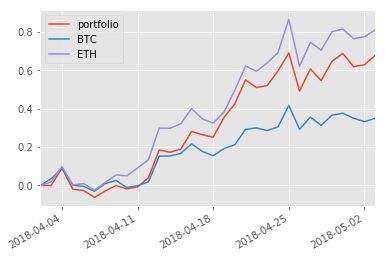

In [91]:
import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

perf.portfolio_value.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='portfolio')
perf.BTC.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='BTC')
perf.ETH.pct_change().fillna(0).add(1).cumprod().sub(1).plot(label='ETH')

plt.legend(loc=2)  
plt.show()